# Time-Series Forecasting | Corporación Favorita Grocery Sales
## Section 3: XGBoost with Hyperparameter Tuning
### 1 - Notebook Overview

In this notebook, I transition from data exploration to active forecasting. I have selected **XGBoost** for this phase because its gradient-boosted decision trees are exceptionally well-suited for capturing the non-linear relationships and complex interactions between my engineered features.

While my **ADF test yielded a p-value of 0.0430**, suggesting marginal stationarity, my subsequent analysis revealed a **Trend Strength of 0.73** and a **Seasonality Strength of 0.59**. These metrics confirm that the series is heavily influenced by a dominant long-term direction and significant periodic cycles rather than being "white noise." **XGBoost** is an ideal choice here as it can effectively model this structured complexity by utilizing my time-based features—such as lags, rolling averages, and holiday flags—to target the `January–March 2014` forecast horizon for the **Guayas** region.

---

### 2 - Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import time

# Data visualization
import matplotlib.pyplot as plt

# Machine learning libraries
import xgboost as xgb

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### 3 - Data Ingestion

In [2]:
# Load training data
df_train = pd.read_pickle('../data/train_models.pkl')

# # Check shape
print(f"Shape: {df_train.shape}")

# Check memory usage
memory_gb = df_train.memory_usage(deep=True).sum() / (1024**3)
print(f"Memory: {memory_gb:.2f} GB")

# Check column data types
print("\nColumn Data Types:")
print("-" * 50)
print(df_train.dtypes)

# Check for missing values
print("\nMissing Values per Column:")
print("-" * 50)
display(df_train.isnull().sum())

# Display first 3 rows
print("\nDataset Preview:")
print("-" * 50)
display(df_train.head(3))

Shape: (18680367, 15)
Memory: 1.67 GB

Column Data Types:
--------------------------------------------------
date                  datetime64[ns]
store_nbr                      int32
item_nbr                       int32
unit_sales                   float64
onpromotion                    int32
year                           int32
month                          int32
day                            int32
day_of_week                    int32
is_holiday                     int32
unit_sales_7d_avg            float64
unit_sales_14d_avg           float64
unit_sales_lag_1             float64
unit_sales_lag_7             float64
unit_sales_lag_30            float64
dtype: object

Missing Values per Column:
--------------------------------------------------


date                  0
store_nbr             0
item_nbr              0
unit_sales            0
onpromotion           0
year                  0
month                 0
day                   0
day_of_week           0
is_holiday            0
unit_sales_7d_avg     0
unit_sales_14d_avg    0
unit_sales_lag_1      0
unit_sales_lag_7      0
unit_sales_lag_30     0
dtype: int64


Dataset Preview:
--------------------------------------------------


,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,is_holiday,unit_sales_7d_avg,unit_sales_14d_avg,unit_sales_lag_1,unit_sales_lag_7,unit_sales_lag_30
30,2013-07-08,24,96995,0.0,0,2013,7,8,0,0,0.0,0.0,0.0,0.0,2.0
31,2013-07-09,24,96995,0.0,0,2013,7,9,1,0,0.0,0.0,0.0,0.0,0.0
32,2013-07-10,24,96995,0.0,0,2013,7,10,2,0,0.0,0.0,0.0,0.0,0.0


### 4 - Time-Series Slicing

In [3]:
# Define 2014 forecast dates
start_date = '2014-01-01'
end_date = '2014-03-31'

# Create training datset of 2013 data
train_data = df_train[df_train['date'] < start_date].copy()

# Create validation dataset of first quarter 2014 data
val_data = df_train[(df_train['date'] >= start_date) & (df_train['date'] <= end_date)].copy()

# Check shapes of training and validation datasets
print("TRAINING DATASET")
print("-" * 50)
print(f"Shape: {train_data.shape}")
print("Start date:", train_data['date'].min())
print("End date:", train_data['date'].max())
print("\nVALIDATION DATASET")
print("-" * 50)
print(f"Shape: {val_data.shape}")
print("Start date:", val_data['date'].min())
print("End date:", val_data['date'].max())

TRAINING DATASET
--------------------------------------------------
Shape: (2069024, 15)
Start date: 2013-02-01 00:00:00
End date: 2013-12-31 00:00:00

VALIDATION DATASET
--------------------------------------------------
Shape: (828178, 15)
Start date: 2014-01-01 00:00:00
End date: 2014-03-31 00:00:00


### 5 - Feature & Target Selection

In [4]:
# Define target column and features for modeling
target = 'unit_sales'
features = [
    # Exclude non-numerical ('date') and identifier ('store_nbr', 'item_nbr') columns
    'onpromotion', 'year', 'month', 'day', 'day_of_week', 'is_holiday',
    'unit_sales_7d_avg', 'unit_sales_14d_avg', 
    'unit_sales_lag_1', 'unit_sales_lag_7', 'unit_sales_lag_30'
]

# Create X and y splits
X_train = train_data[features]
y_train = train_data[target]

X_val = val_data[features]
y_val = val_data[target]

### 6 - XGBoost Model Training 

In [5]:
# Initialize the XGBoost Regressor
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    n_jobs=-1
)

# Record the start time
start_time = time.time()

# Fit the model
model.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate training time
training_duration = end_time - start_time

### 7 - Feature Importance

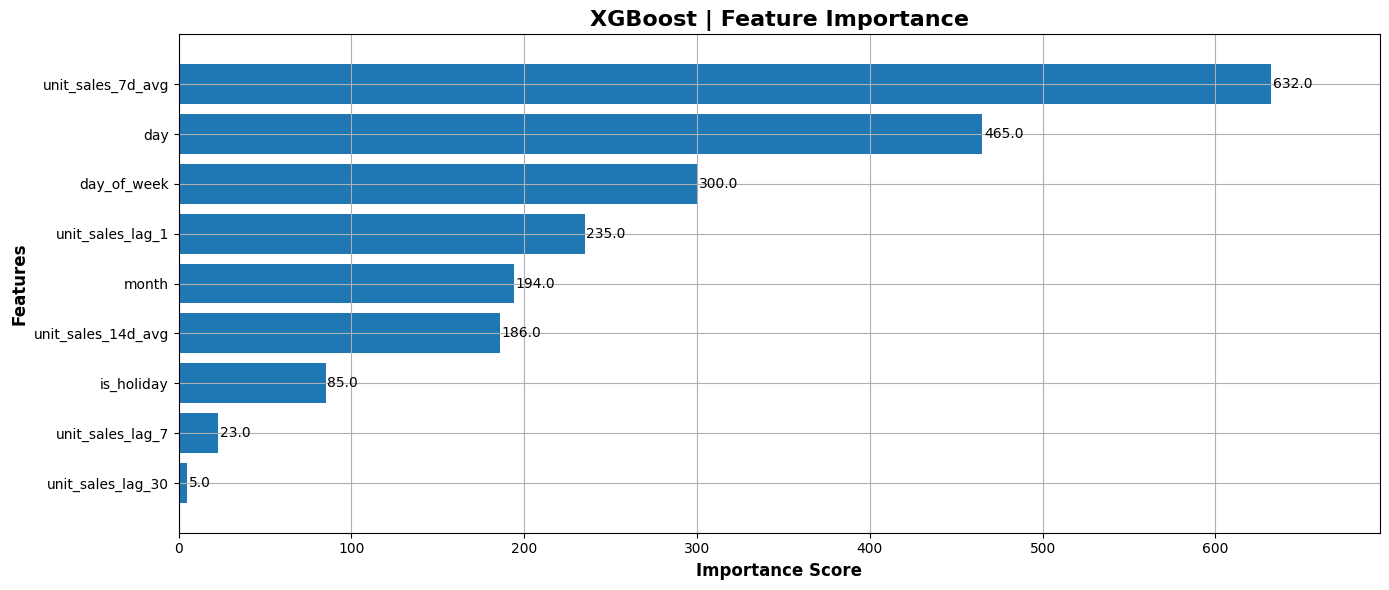

In [6]:
# Visualizes which features the model considers most important for making predictions
plt.figure(figsize=(14, 6))
xgb.plot_importance(model, height=0.8, ax=plt.gca(), importance_type='weight')
plt.title('XGBoost | Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure
plt.savefig('../visualizations/xgboost-feature-importance.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

### 8 - Forecasting

In [7]:
# Make predictions on the test set
y_pred = model.predict(X_val)

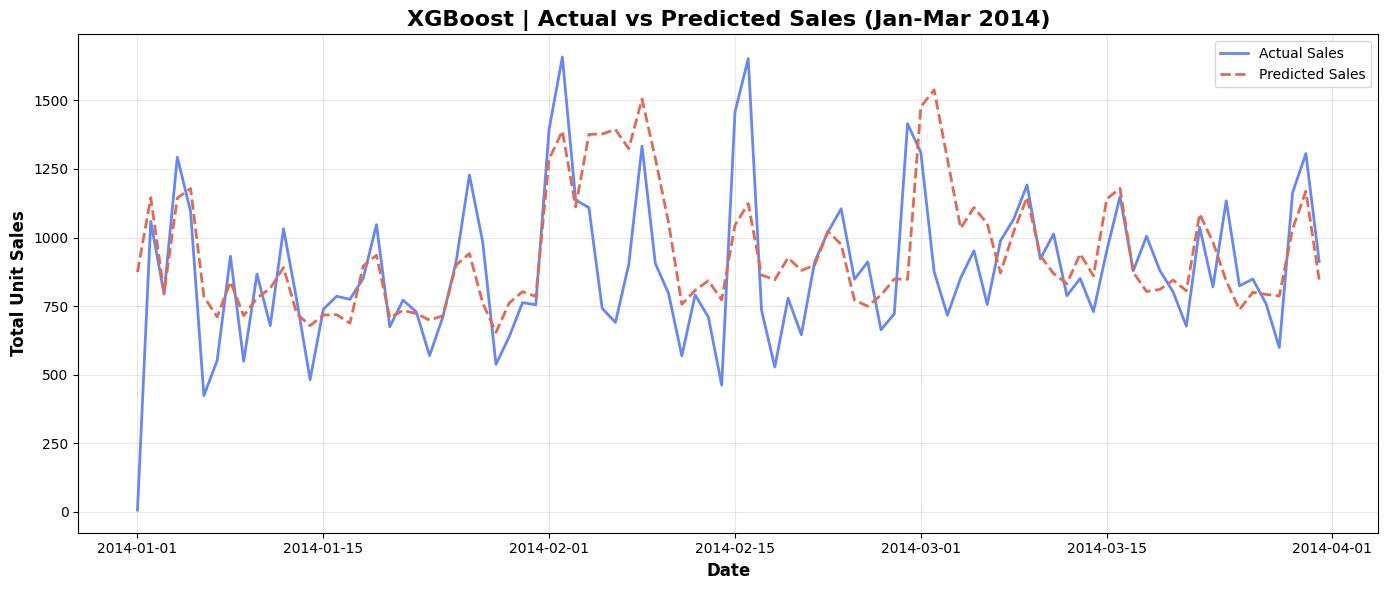

In [8]:
# Create a temporary DataFrame to aggregate results by date
results = pd.DataFrame({
    'date': val_data['date'],
    'actual': y_val,
    'predicted': y_pred
})

# Aggregate by date so the plot shows the TOTAL sales per day for the region
daily_results = results.groupby('date').sum()

# Plotting Actual vs Predicted Sales
plt.figure(figsize=(14, 6))
plt.plot(daily_results.index, daily_results['actual'], label='Actual Sales', color='#6788ee', linewidth=2)
plt.plot(daily_results.index, daily_results['predicted'], label='Predicted Sales', color='#e26952', linewidth=2, linestyle='--')

# Add Title and Labels
plt.title('XGBoost | Actual vs Predicted Sales (Jan-Mar 2014)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Total Unit Sales', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.grid(True, alpha=0.3)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure
plt.savefig('../visualizations/xgboost-actual-vs-predicted.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

### 9 -  Evaluation Metrics

In [9]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
bias = np.mean(y_pred - y_val)
r2 = r2_score(y_val, y_pred)

print("XGBoost Model Evaluation Metrics")
print("-" * 50)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Bias: {bias:.2f}")
print(f"R-Squared Score: {r2:.2f}")

# Print training time
minutes = int(training_duration // 60)
seconds = int(training_duration % 60)
print(f"Training Time: {minutes:02d}:{seconds:02d}")

XGBoost Model Evaluation Metrics
--------------------------------------------------
Mean Absolute Error (MAE): 0.16
Mean Squared Error (MSE): 3.34
Root Mean Squared Error (RMSE): 1.83
Bias: 0.01
R-Squared Score: -0.17
Training Time: 00:01


### 10 - Conclusion

The **XGBoost** model was successfully trained on 2013 data and evaluated against 2014 Q1 sales. General conclusions:

- **Accuracy vs. Variance:** The model achieved a very low **Mean Absolute Error (0.16)**, indicating that for the vast majority of items and days, the predictions are very close to the actual sales. However, the negative **R-Squared score (-0.17)** reveals that the model is "conservative". While it is excellent at predicting the frequent low-volume days, it struggles to capture the magnitude of high-volume sales spikes (outliers).
- **Momentum:** The analysis proves that short-term behavior is the strongest predictor. The model relies heavily on the 7-day rolling average and immediate lags, suggesting that in the Ecuadorian retail market, "what happened last week" is a more reliable indicator than "what happened last year."
- **Model Reliability:** With a **Bias of 0.01**, the model is nearly perfectly centered. It is not systematically over-predicting or under-predicting sales, making it a "safe" baseline for inventory planning, even if it doesn't yet capture the full volatility of promotional peaks.

While the ADF test in [Section 2: Exploratory Data Analysis](/notebooks/02-exploratory-data-analysis.ipynb) suggested marginal stationarity, the model’s performance confirms that the data is still heavily driven by structured temporal patterns. For the `Guayas` region, this **XGBoost** approach successfully automates the identification of weekly cycles and holiday impacts.